# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
%matplotlib inline

plt.style.use('seaborn-colorblind')

# Read Data

In [2]:
df = pd.read_csv('level_set_results.csv')
df.head()

,image_no,category,our_evaluation,radiologist_evaluation
0,1,0,0,0
1,2,2,-1,-1
2,3,0,1,1
3,4,0,1,0
4,5,0,1,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   image_no                322 non-null    int64
 1   category                322 non-null    int64
 2   our_evaluation          322 non-null    int64
 3   radiologist_evaluation  322 non-null    int64
dtypes: int64(4)
memory usage: 10.2 KB


In [4]:
# rename the numbers to human-friendly values
category_original = [0, 1, 2, 3, 4]
category_meaning = [
    'normal',
    'internal boundary',
    'corrupted',
    'no muscle',
    'no boundary'
]
evaluation_original = [-1, 0, 1]
evaluation_meaning = [
    'anomaly',
    'unacceptable',
    'acceptable'
]

df['category'] = df['category'].replace(category_original, category_meaning)
df['our_evaluation'] = df['our_evaluation'].replace(evaluation_original, evaluation_meaning)
df['radiologist_evaluation'] = df['radiologist_evaluation'].replace(evaluation_original, evaluation_meaning)

df.head()

,image_no,category,our_evaluation,radiologist_evaluation
0,1,normal,unacceptable,unacceptable
1,2,corrupted,anomaly,anomaly
2,3,normal,acceptable,acceptable
3,4,normal,acceptable,unacceptable
4,5,normal,acceptable,acceptable


# Analysis

Let's analyse the data!

### Comparison of Our Evaluation to Radiologist's Evaluation


Let's see how much difference there lies in the evaluations.

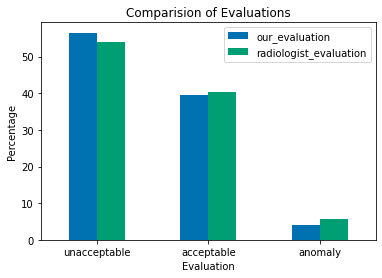

In [5]:
# radiologist accuracy score
radiologist_evaluation_summary = df['radiologist_evaluation'].value_counts(normalize=True) * 100
radiologist_evaluation_summary = radiologist_evaluation_summary.to_frame()

# our accuracy score
our_evaluation_summary = df['our_evaluation'].value_counts(normalize=True) * 100
our_evaluation_summary = our_evaluation_summary.to_frame()

combined_evaluation_summary = pd.concat([our_evaluation_summary, radiologist_evaluation_summary], axis=1)

# visualize
ax = combined_evaluation_summary.plot(kind="bar", rot=0)
plt.title("Comparision of Evaluations")
plt.xlabel("Evaluation")
plt.ylabel("Percentage")
plt.show()

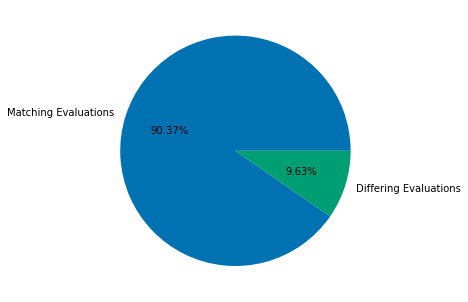

In [6]:
# percent of images we agreed on
matches = round(len(df[df['our_evaluation'] == df['radiologist_evaluation']]) / len(df) * 100, 2)

# percent of images we differ on
differs = round(len(df[df['our_evaluation'] != df['radiologist_evaluation']]) / len(df) * 100, 2)

# visualize
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
langs = ['Matching Evaluations', 'Differing Evaluations']
students = [matches, differs]
ax.pie(students, labels = langs, autopct='%1.2f%%')
plt.show()

#### We can see that the evaluations are very similar so moving forward, we will only use the radiologist's evaluations.

In [8]:
df_categorised = df.groupby(by=['category', 'radiologist_evaluation']).size().to_frame('count').reset_index()
df_categorised

,category,radiologist_evaluation,count
0,corrupted,acceptable,5
1,corrupted,anomaly,8
2,corrupted,unacceptable,1
3,internal boundary,acceptable,5
4,internal boundary,anomaly,9
5,internal boundary,unacceptable,69
6,no boundary,acceptable,2
7,no boundary,unacceptable,6
8,no muscle,acceptable,6
9,no muscle,unacceptable,2


In [9]:
df_pivot = pd.pivot_table(
    df_categorised,
    values="count",
    index="category",
    columns="radiologist_evaluation",
    fill_value=0
)

df_pivot

radiologist_evaluation,acceptable,anomaly,unacceptable
category,,,
corrupted,5,8,1
internal boundary,5,9,69
no boundary,2,0,6
no muscle,6,0,2
normal,112,1,96


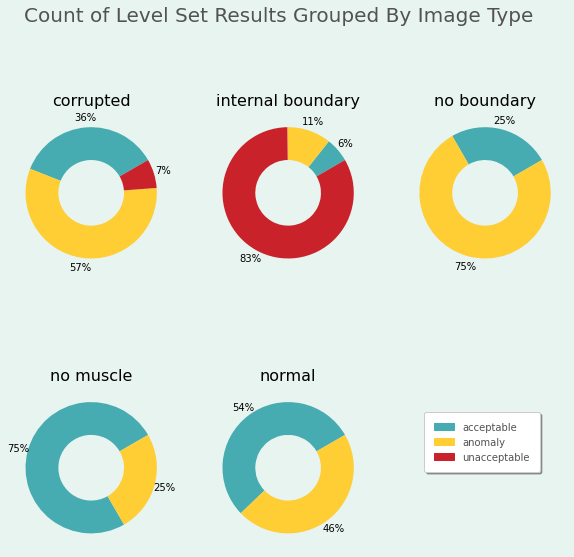

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(10, 10), facecolor='#e8f4f0')
fig.delaxes(ax= axes[1,2])

font_color = '#525252'
colors = ['#47ACB1', '#FFCD34', '#C9222B']

for i, (idx, row) in enumerate(df_pivot.head(8).iterrows()):
    ax = axes[i // 3, i % 3]
    row = row[row.gt(row.sum() * .01)]
    ax.pie(row, 
#            labels=row.values,
           startangle=30, 
           wedgeprops=dict(width=.5), # For donuts,
           colors = colors,
           autopct='%.0f%%',
           pctdistance=1.15
          )
    ax.set_title(idx, fontsize=16)
    
    green_patch = mpatches.Patch(color='#47ACB1', label='acceptable')
    yellow_patch = mpatches.Patch(color='#FFCD34', label='anomaly')
    red_patch = mpatches.Patch(color='#C9222B', label='unacceptable')
    legend = plt.legend(handles=[green_patch, yellow_patch, red_patch],
                        bbox_to_anchor=(1.3, .87), # Legend position
                        loc='upper left',  
                        ncol=1,
                        fancybox=True, 
                        framealpha=1, 
                        shadow=True, 
                        borderpad=1)
    
    for text in legend.get_texts():
        plt.setp(text, color=font_color) # Legend font color

fig.subplots_adjust(wspace=.2) # Space between charts

title = fig.suptitle('Count of Level Set Results Grouped By Image Type', y=.95, fontsize=20, color=font_color)
# To prevent the title from being cropped
plt.subplots_adjust(top=0.85, bottom=0.15)